In [2]:
# imports
import numpy as np

### Photon Efficiency

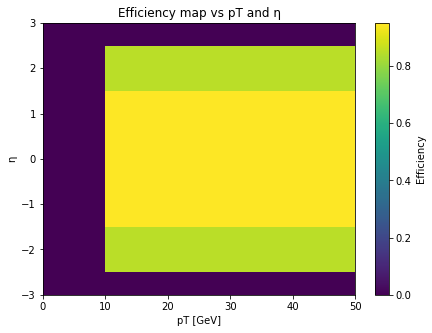

In [3]:
# Default Efficiency

import numpy as np
import matplotlib.pyplot as plt

# Define grid
pt = np.linspace(0, 50, 500)
eta = np.linspace(-3, 3, 500)
PT, ETA = np.meshgrid(pt, eta)

# Efficiency formula
eff = (
    (PT <= 10.0) * 0.00 +
    (np.abs(ETA) <= 1.5) * (PT > 10.0) * 0.95 +
    ((np.abs(ETA) > 1.5) & (np.abs(ETA) <= 2.5)) * (PT > 10.0) * 0.85 +
    (np.abs(ETA) > 2.5) * 0.00
)

# Plot
plt.figure(figsize=(7, 5))
plt.pcolormesh(PT, ETA, eff, shading='auto')
plt.colorbar(label='Efficiency')
plt.xlabel('pT [GeV]')
plt.ylabel('η')
plt.title('Efficiency map vs pT and η')
plt.show()

### Muon momentum resolution

$\frac{\sigma(p_T)}{p_T} = \frac{r_0}{p_T} \oplus r_1 \oplus r_2 \cdot p_T$

which is equal to

$\frac{\sigma(p_T)}{p_T} = \sqrt{\left(\frac{r_0}{p_T} \right)^2 + r_1^2 + (r_2\cdot p_T)^2}$

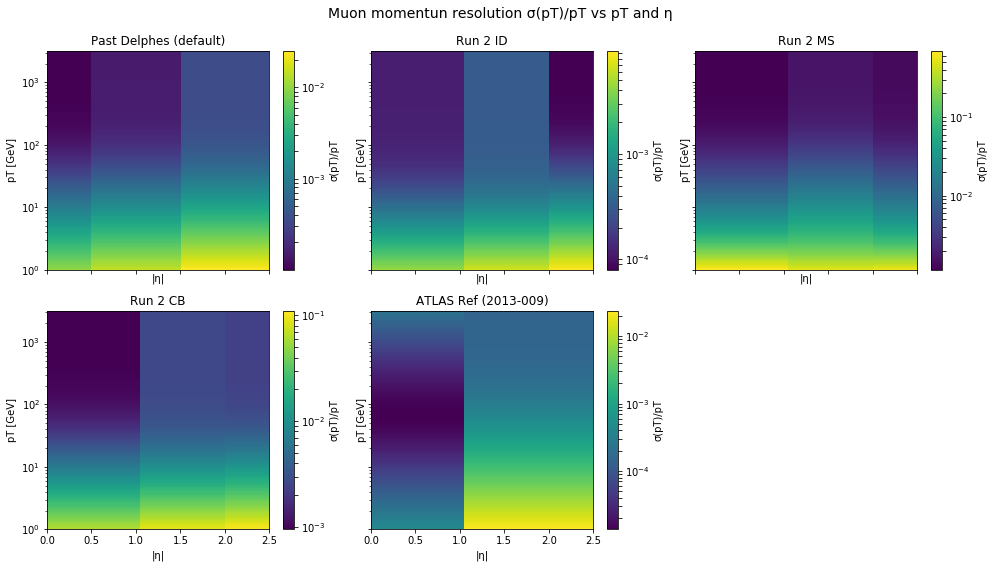

In [4]:
# Study link: https://arxiv.org/pdf/2212.07338

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # <-- add this

# Define eta and pT grids
etas = np.linspace(0, 2.5, 200)
pts  = np.logspace(0, 3.5, 200)  # 1 GeV to ~3160 GeV
E, P = np.meshgrid(etas, pts)

scale = 10e-3
# ---------- OLD (past) resolution ----------
def past_res(pt, eta):
    return ((abs(eta) <= 0.5) * (pt > 0.1)* np.sqrt(0.01**2 + (pt*1.0e-4)**2)
          + ((abs(eta) > 0.5) & (abs(eta) <= 1.5)) * (pt > 0.1) * np.sqrt(0.015**2 + (pt*1.5e-4)**2)
          + ((abs(eta) > 1.5) & (abs(eta) <= 2.5)) * (pt > 0.1) * np.sqrt(0.025**2 + (pt*3.5e-4)**2))

# ---------- ID resolution ----------
def id_res(pt, eta):
    return ((abs(eta) < 1.05) * np.sqrt(0.0044**2 + (0.00012*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt(0.0067**2 + (0.00031*pt)**2) +
            (abs(eta) >= 2.0)  * np.sqrt(0.0094**2 + (0.00008*pt)**2))

# ---------- MS resolution ----------
def ms_res(pt, eta):
    return ((abs(eta) < 1.05) * np.sqrt((((71+63)/2)*scale/pt)**2 + (((13.5+17.2)/2)*scale)**2 + (((0.11+0.12)/2)*scale*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt((((42+44)/2)*scale/pt)**2 + (((26.7+29.2)/2)*scale)**2 + (((0.14+0.18)/2)*scale*pt)**2) +
            (abs(eta) >= 2.0) * np.sqrt((((61+47)/2)*scale/pt)**2 + (((16.8 + 17.8)/2)*scale)**2 + (((0.11+0.16)/2)*scale*pt)**2))

# ---------- CB resolution ----------
def cb_res(pt, eta):
    return ((abs(eta) <= 1.05) * np.sqrt((((6.7+6.5)/2)*scale)**2 + (((0.08 + 0.11)/2)*scale*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt((((10.3+8.9)/2)*scale)**2 + (((0.24 + 0.29)/2)*scale*pt)**2) +
            (abs(eta) >= 2.0) * np.sqrt((((10.6+11.5)/2)*scale)**2 + (((0.21 + 0.26)/2)*scale*pt)**2))

# ATLAS reference (ATL-PHYS-PUB-2013-009)
def atlas_ref(pt, eta):
    term_inner_A = pt*np.sqrt((0.24/pt)**2 + 0.02676**2 + (0.00012*pt)**2)
    term_outer_A = pt*np.sqrt(0.0388**2 + (0.00016*pt)**2)
    term_inner_C = np.sqrt(0.01607**2 + (0.000307*pt)**2)
    term_outer_B = np.sqrt(0.03**2 + (0.000387*pt)**2)
    term_inner_B = pt*np.sqrt(0.01061**2 + (0.000157*pt)**2)
    
    num = ( (abs(eta)<1.05)*term_inner_A*term_inner_C + (abs(eta)>=1.05)*term_outer_A ) * np.sqrt(0.03**2 + (0.000387*pt)**2)
    den = np.sqrt( ((abs(eta)<1.05)*term_inner_A + (abs(eta)>=1.05)*term_outer_A)**2 +
                   ((abs(eta)<1.05)*term_inner_B + (abs(eta)>=1.05)*pt*np.sqrt(0.03**2 + (0.000387*pt)**2))**2 )
    return num/den


# ---------- Compute fractional resolutions ----------
past_frac = past_res(P, E) / P
id_frac   = id_res(P, E) / P
ms_frac   = ms_res(P, E) / P
cb_frac   = cb_res(P, E) / P
atlas_frac = atlas_ref(P, E)/P

# ---------- Plot ----------
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle("Muon momentun resolution σ(pT)/pT vs pT and η", fontsize=14)

def make_plot(ax, Z, title):
    im = ax.pcolormesh(E, P, Z, shading='auto', cmap='viridis', norm=LogNorm())  # <-- fixed
    ax.set_title(title)
    ax.set_xlabel("|η|")
    ax.set_ylabel("pT [GeV]")
    ax.set_yscale('log')
    plt.colorbar(im, ax=ax, label="σ(pT)/pT")
    return im

make_plot(axs[0,0], past_frac,  "Past Delphes (default)")
make_plot(axs[0,1], id_frac,    "Run 2 ID")
make_plot(axs[0,2], ms_frac,    "Run 2 MS")
make_plot(axs[1,0], cb_frac,    "Run 2 CB")
make_plot(axs[1,1], atlas_frac, "ATLAS Ref (2013-009)")
axs[1,2].axis('off')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

### Charged Hadron Tracking Efficiency

Paper: https://arxiv.org/pdf/1704.07983

Figure 14.a



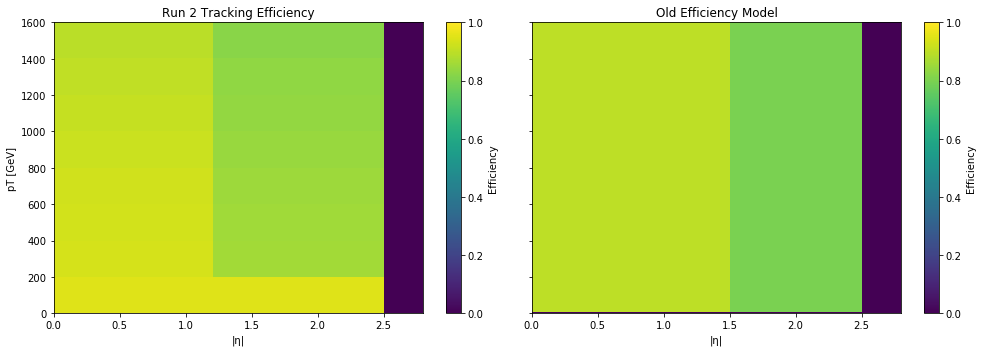

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define eta and pT grids
etas = np.linspace(0, 2.8, 200)
pts  = np.linspace(0, 1600, 200)
E, P = np.meshgrid(etas, pts)

# --- Original efficiency function ---
def tracking_eff(pt, eta):
    # Barrel region (|η| <= 1.2)
    eff_barrel = (
        (pt < 200)*0.95 +
        ((pt >= 200) & (pt < 400))*0.93687 +
        ((pt >= 400) & (pt < 600))*0.93296 +
        ((pt >= 600) & (pt < 800))*0.92654 +
        ((pt >= 800) & (pt < 1000))*0.92011 +
        ((pt >= 1000) & (pt < 1200))*0.91257 +
        ((pt >= 1200) & (pt < 1400))*0.90531 +
        ((pt >= 1400) & (pt < 1600))*0.89721
    )

    # Endcap region (1.2 < |η| < 2.5)
    eff_endcap = (
        (pt < 200)*0.95 +
        ((pt >= 200) & (pt < 400))*0.86145 +
        ((pt >= 400) & (pt < 600))*0.85838 +
        ((pt >= 600) & (pt < 800))*0.85251 +
        ((pt >= 800) & (pt < 1000))*0.84749 +
        ((pt >= 1000) & (pt < 1200))*0.83939 +
        ((pt >= 1200) & (pt < 1400))*0.83212 +
        ((pt >= 1400) & (pt < 1600))*0.82039
    )

    # Combine all η regions
    return (
        (np.abs(eta) <= 1.2)*eff_barrel +
        ((np.abs(eta) > 1.2) & (np.abs(eta) < 2.5))*eff_endcap +
        (np.abs(eta) >= 2.5)*0
    )

# Compute efficiency for original function
Z = tracking_eff(P, E)

# # ---------- Plot original 2D map ----------
# plt.figure(figsize=(7,5))
# plt.pcolormesh(E, P, Z, shading='auto', cmap='viridis', vmin=0, vmax=1)
# plt.colorbar(label="Tracking Efficiency")
# plt.title("Muon Tracking Efficiency vs pT and |η| (Original)")
# plt.xlabel("|η|")
# plt.ylabel("pT [GeV]")
# plt.ylim(0, 1600)
# plt.show()

# ---------------------------------------------------------------------
# --- NEW efficiency function from your provided piecewise formula ---
def new_eff(pt, eta):
    return (
        (pt <= 0.5) * 0.00 +
        (np.abs(eta) <= 1.5) * (pt > 0.5) * (pt <= 5.0) * 0.85 +
        (np.abs(eta) <= 1.5) * (pt > 5.0) * 0.90 +
        (np.abs(eta) > 1.5) * (np.abs(eta) <= 2.5) * (pt > 0.5) * (pt <= 5.0) * 0.75 +
        (np.abs(eta) > 1.5) * (np.abs(eta) <= 2.5) * (pt > 5.0) * 0.80 +
        (np.abs(eta) > 2.5) * 0.00
    )

# Compute new efficiency
Z_new = new_eff(P, E)

# ---------- Compare the two models ----------
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Original
im0 = axes[0].pcolormesh(E, P, Z, shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[0].set_title("Run 2 Tracking Efficiency")
axes[0].set_xlabel("|η|")
axes[0].set_ylabel("pT [GeV]")
fig.colorbar(im0, ax=axes[0], label="Efficiency")

# New model
im1 = axes[1].pcolormesh(E, P, Z_new, shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("Old Efficiency Model")
axes[1].set_xlabel("|η|")
fig.colorbar(im1, ax=axes[1], label="Efficiency")

plt.tight_layout()
plt.show()


### Electron Tracking Efficiency
Paper: https://cds.cern.ch/record/2868520/files/ANA-EGAM-2021-01-PAPER.pdf

Since the paper stated that the reconstruction efficiency reflects the performance of the track reconstruction. I will use the reconstruction efficiency as the efficiency for the tracks. 

In [6]:
# x is the eta values while y is the efficiency (for pt > 15 GeV)
e_track_eta = np.genfromtxt("data/Electron_Tracking_eta.csv", delimiter=",", skip_header = 1)
# x is the pt values while y is the efficiency (for |eta| < 2.47)
e_track_pt = np.genfromtxt("data/Electron_Tracking_pt.csv", delimiter=",", skip_header=1)
# Process the intervals
e_track_eta_eff = {}
e_track_pt_eff = {}
for i in range(len(e_track_eta)):
    if i%2 == 0:
        eff = e_track_eta[i][1]
        eta1 = e_track_eta[i][0]
        eta2 = e_track_eta[i+1][0]

        e_track_eta_eff[f"{eff}_{i//2}"] = (eta1, eta2)

for i in range(len(e_track_pt)):
    if i%2 == 0:
        eff = e_track_pt[i][1]
        pt1 = e_track_pt[i][0]
        pt2 = e_track_pt[i+1][0]

        e_track_pt_eff[f"{eff}_{i//2}"] = (pt1, pt2)


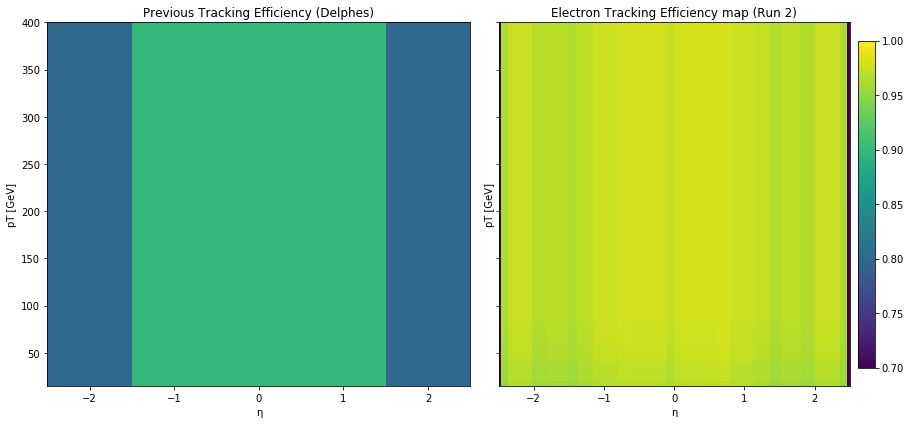

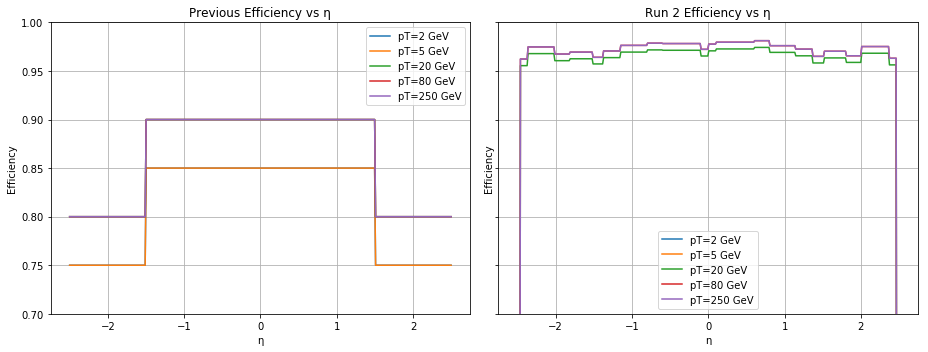

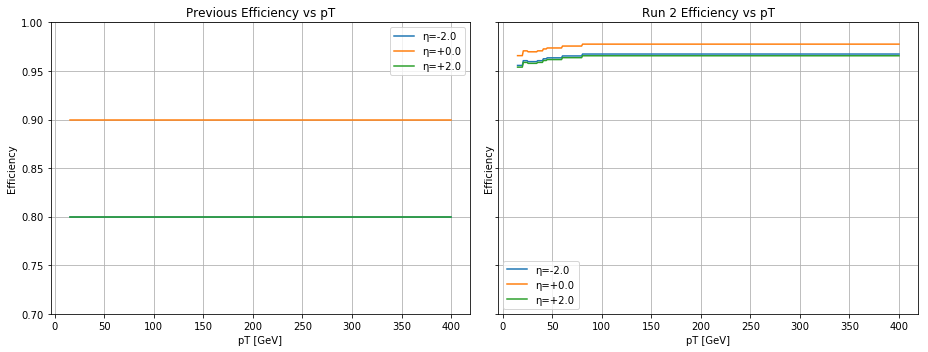

In [ ]:
etas = np.linspace(-2.5, 2.5, 400)
pts = np.linspace(15, 400, 400)
E, P = np.meshgrid(etas, pts)

def eff_eta(eta):
    for k, (emin, emax) in e_track_eta_eff.items():
        val = float(k.split('_')[0])
        if emin <= eta < emax:
            return val
    return 0.0

def eff_pt(pt):
    for k, (pmin, pmax) in e_track_pt_eff.items():
        val = float(k.split('_')[0])
        if pmin <= pt < pmax:
            return val
    if pt >= 249.66:
        return 0.99
    return 0.0

# --- Previous (Delphes) tracking efficiency ---
def old_eff(pt, eta):
    if pt <= 0.5:
        return 0.0
    elif abs(eta) <= 1.5:
        if pt <= 5.0:
            return 0.85
        else:
            return 0.90
    elif abs(eta) <= 2.5:
        if pt <= 5.0:
            return 0.75
        else:
            return 0.80
    else:
        return 0.0

# Vectorized
v_eff_eta = np.vectorize(eff_eta)
v_eff_pt = np.vectorize(eff_pt)
v_old_eff = np.vectorize(old_eff)

# Combined efficiencies
Z_new = v_eff_eta(E) * v_eff_pt(P)
Z_old = v_old_eff(P, E)

# === 2D heatmap comparison ===
fig, ax = plt.subplots(1, 2, figsize=(13,6), sharex=True, sharey=True)
im0 = ax[0].pcolormesh(E, P, Z_old, shading='auto', cmap='viridis', vmin=0.7, vmax=1.0)
im1 = ax[1].pcolormesh(E, P, Z_new, shading='auto', cmap='viridis', vmin=0.7, vmax=1.0)
cbar1 = plt.colorbar(im1, ax=ax[1], pad=0.02, shrink=0.9)
ax[0].set_title("Previous Tracking Efficiency (Delphes)")
ax[1].set_title("Electron Tracking Efficiency map (Run 2)")
for a in ax:
    a.set_xlabel("η")
    a.set_ylabel("pT [GeV]")
    # a.set_yscale("log")
    # a.set_ylim(0.5, 400)
# fig.colorbar(im1, ax=ax, label='Tracking Efficiency ε(pT,η)')
plt.tight_layout()
plt.show()

# === Efficiency vs η for fixed pT ===
fig, ax = plt.subplots(1, 2, figsize=(13,5), sharey=True)
for pt_fixed in [2, 5, 20, 80, 250]:
    ax[0].plot(etas, v_old_eff(pt_fixed, etas), label=f"pT={pt_fixed:.0f} GeV")
    ax[1].plot(etas, v_eff_eta(etas)*eff_pt(pt_fixed), label=f"pT={pt_fixed:.0f} GeV")
for a in ax:
    a.set_xlabel("η")
    a.set_ylabel("Efficiency")
    a.grid(True)
    a.legend()
ax[0].set_title("Previous Efficiency vs η")
ax[1].set_title("Run 2 Efficiency vs η")
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# === Efficiency vs pT for fixed η ===
fig, ax = plt.subplots(1, 2, figsize=(13,5), sharey=True)
for eta_fixed in [-2.0, 0.0, 2.0]:
    ax[0].plot(pts, v_old_eff(pts, eta_fixed), label=f"η={eta_fixed:+.1f}")
    ax[1].plot(pts, v_eff_pt(pts)*eff_eta(eta_fixed), label=f"η={eta_fixed:+.1f}")
for a in ax:
    a.set_xlabel("pT [GeV]")
    a.set_ylabel("Efficiency")
    a.grid(True)
    a.legend()
ax[0].set_title("Previous Efficiency vs pT")
ax[1].set_title("Run 2 Efficiency vs pT")
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

### Muon Tracking Efficiency

Paper: https://cds.cern.ch/record/2746302/files/Aad2021_Article_MuonReconstructionAndIdentific.pdf


In [14]:
# x is the eta values while y is the efficiency (for pt > 15 GeV)
mu_track_eta_tight = np.genfromtxt("data/Muon Tracking - tight_eta.csv", delimiter=",", skip_header = 1)
mu_track_eta_medium = np.genfromtxt("data/Muon Tracking - medium_eta.csv", delimiter=",", skip_header = 1)
mu_track_eta_loose = np.genfromtxt("data/Muon Tracking - loose_eta.csv", delimiter=",", skip_header = 1)
# x is the pt values while y is the efficiency (for |eta| < 2.47)
mu_track_pt_tight = np.genfromtxt("data/Muon Tracking - tight_pt.csv", delimiter=",", skip_header = 1)
mu_track_pt_medium = np.genfromtxt("data/Muon Tracking - medium_pt.csv", delimiter=",", skip_header = 1)
mu_track_pt_loose = np.genfromtxt("data/Muon Tracking - loose_pt.csv", delimiter=",", skip_header = 1)

mu_track_eta = [mu_track_eta_tight, mu_track_eta_medium, mu_track_eta_loose]
mu_track_pt = [mu_track_pt_tight, mu_track_pt_medium, mu_track_pt_loose]

# Process the intervals
mu_track_info = {}
quality = ["tight", "medium", "loose"]
for qual in quality:
    mu_track_info[qual] = {
        "pt": [],
        "eta": [] 
    }
for c, qual in enumerate(quality):
    for i in range(len(mu_track_eta_loose)):
        if i%2 == 0:
            eff = round(mu_track_eta[c][i][1], 3)
            eta1 = round(mu_track_eta[c][i][0], 3)
            eta2 = round(mu_track_eta[c][i+1][0], 3)
            
            mu_track_info[qual]["eta"].append((eff, (eta1, eta2)))
            

    for i in range(len(mu_track_pt_loose)):
        if i%2 == 0:
            eff = round(mu_track_pt[c][i][1], 3)
            pt1 = round(mu_track_pt[c][i][0], 3)
            pt2 = round(mu_track_pt[c][i+1][0], 3)

            mu_track_info[qual]["pt"].append((eff, (pt1, pt2)))


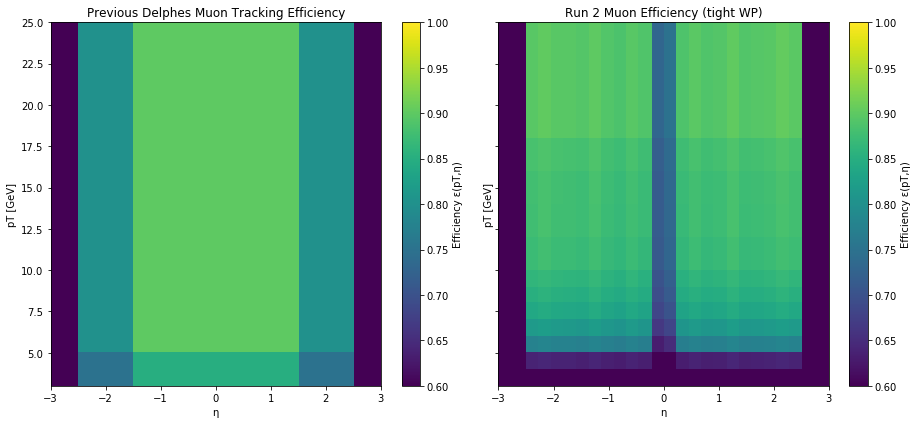

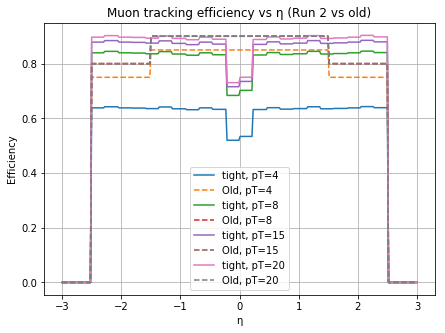

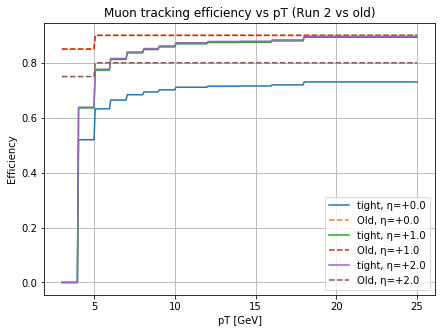

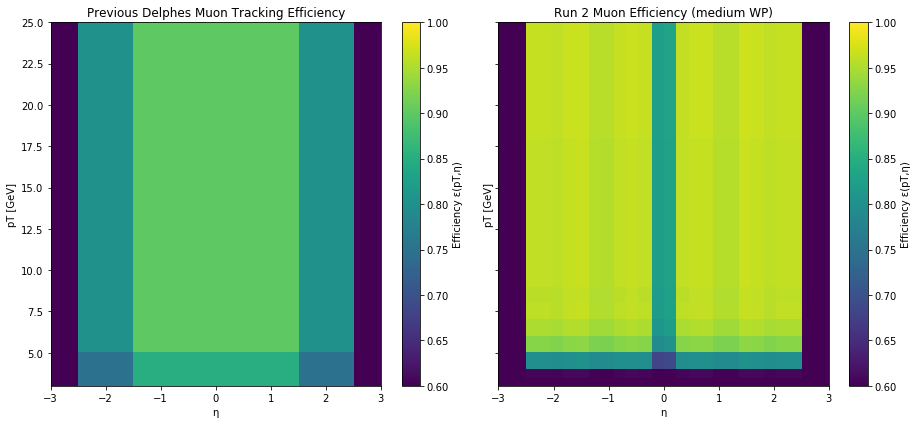

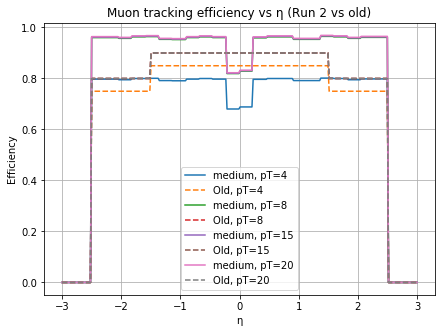

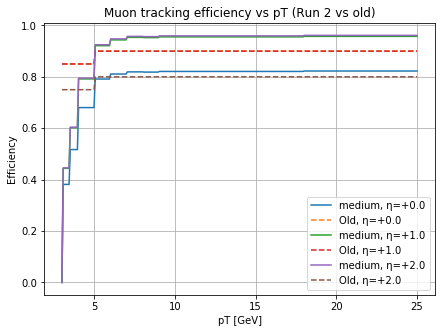

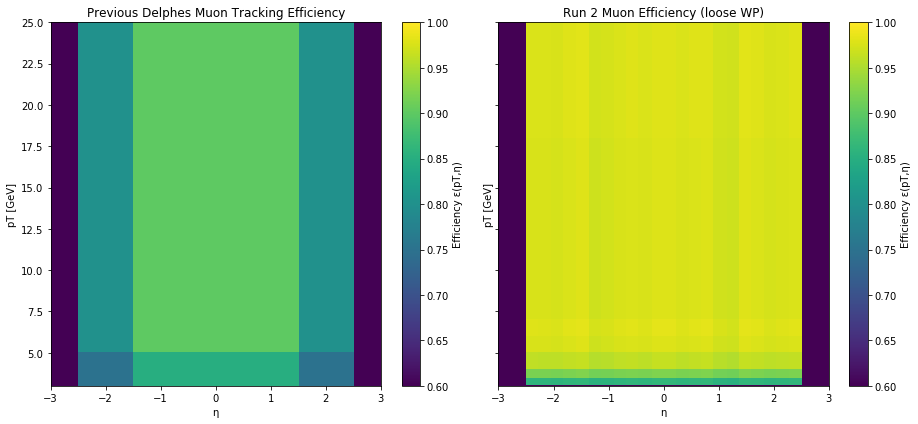

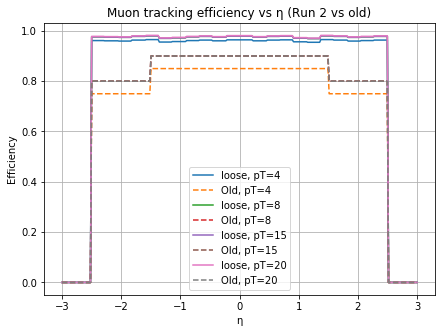

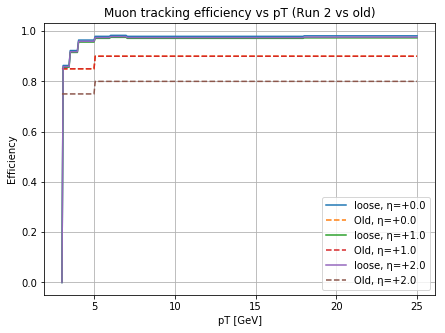

In [22]:
# === Helper functions ===
def eff_from_dict(info, var, value):
    for eff, (vmin, vmax) in info[var]:
        if vmin <= value < vmax:
            return eff
    # for pT > 20 keep last
    if var == "pt" and value >= info[var][-1][1][1]:
        return info[var][-1][0]
    return 0.0

def run2_eff(pt, eta, wp="tight"):
    d = mu_track_info[wp]
    e_pt = eff_from_dict(d, "pt", pt)
    e_eta = eff_from_dict(d, "eta", eta)
    return e_pt * e_eta

def old_eff(pt, eta):
    if pt <= 0.5:
        return 0.0
    elif abs(eta) <= 1.5:
        if pt <= 5.0:
            return 0.85
        else:
            return 0.90
    elif abs(eta) <= 2.5:
        if pt <= 5.0:
            return 0.75
        else:
            return 0.80
    else:
        return 0.0

# === Build grid ===
etas = np.linspace(-3, 3, 300)
pts = np.linspace(3, 25, 300)
E, P = np.meshgrid(etas, pts)
v_old = np.vectorize(old_eff)
v_run2 = np.vectorize(run2_eff)

# === Plot 2D maps for tight WP ===
for qual in quality:

    Z_tight = v_run2(P, E, qual)
    Z_old = v_old(P, E)

    fig, ax = plt.subplots(1, 2, figsize=(13,6), sharex=True, sharey=True)
    im0 = ax[0].pcolormesh(E, P, Z_old, shading='auto', cmap='viridis', vmin=0.6, vmax=1.0)
    im1 = ax[1].pcolormesh(E, P, Z_tight, shading='auto', cmap='viridis', vmin=0.6, vmax=1.0)
    plt.colorbar(im0, ax=ax[0], label='Efficiency ε(pT,η)')
    plt.colorbar(im1, ax=ax[1], label='Efficiency ε(pT,η)')
    ax[0].set_title('Previous Delphes Muon Tracking Efficiency')
    ax[1].set_title(f'Run 2 Muon Efficiency ({qual} WP)')
    for a in ax:
        a.set_xlabel('η')
        a.set_ylabel('pT [GeV]')
    plt.tight_layout()
    plt.show()

    # === 1D projections ===
    plt.figure(figsize=(7,5))
    for pt in [4, 8, 15, 20]:
        plt.plot(etas, v_run2(pt, etas, qual), label=f"{qual}, pT={pt:.0f}")
        plt.plot(etas, v_old(pt, etas), '--', label=f"Old, pT={pt:.0f}")
    plt.xlabel('η')
    plt.ylabel('Efficiency')
    plt.title('Muon tracking efficiency vs η (Run 2 vs old)')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,5))
    for eta in [0.0, 1.0, 2.0]:
        plt.plot(pts, v_run2(pts, eta, qual), label=f"{qual}, η={eta:+.1f}")
        plt.plot(pts, v_old(pts, eta), '--', label=f"Old, η={eta:+.1f}")
    plt.xlabel('pT [GeV]')
    plt.ylabel('Efficiency')
    plt.title('Muon tracking efficiency vs pT (Run 2 vs old)')
    plt.grid(True)
    plt.legend()
    plt.show()
